## Connecting the IMUs

This code connects to the IMUs using the multithreading

In [1]:
import bluetooth
# the witmotion parsing pip package
import pywitmotion as wit
import threading

# address of the IMUs
imu_addr = [
    "00:0C:BF:16:71:33", # 1
    "00:0C:BF:09:46:4B", # 2
    "00:0C:BF:02:1E:40", # 3
    "00:0C:BF:02:3B:42"  # 4
]

# a list containing all quaternion readings
q = [[] for i in imu_addr]

# a callback method for each IMU
def read_from_soc(soc,ind,):
    global q
    data = soc.recv(36)
    while True:
        data = soc.recv(36)
        for msg in reversed(data.split(b'U')):
            q1 = wit.get_quaternion(msg)
            if q1 is not None:
                q[ind]=q1
                break
                
# run the threads and, one for each IMU               
sockets = []
threads = []
for n, imu in enumerate(imu_addr):
    s = bluetooth.BluetoothSocket(bluetooth.RFCOMM)
    try:
        s.connect((imu, 1))
        print("Device {} - {} connected!". format(n,imu))
    except :
        print("Device {} - {} not available!". format(n,imu))
        continue;
    sockets.append(s)
    t = threading.Thread(target=read_from_soc, args=(s,n,))
    t.start()
    threads.append(t)

Device 0 - 00:0C:BF:16:71:33 connected!
Device 1 - 00:0C:BF:09:46:4B connected!
Device 2 - 00:0C:BF:02:1E:40 connected!
Device 3 - 00:0C:BF:02:3B:42 connected!


## Test the connection
Show the quaternions to make sure that all of them are received

In [2]:
q

[array([ 0.13879395, -0.53018188, -0.64581299,  0.53146362]),
 array([-0.08343506, -0.26861572, -0.61483765,  0.73672485]),
 array([-0.31881714,  0.14056396, -0.73196411,  0.5854187 ]),
 []]

## Inverse cinematics using pyomeca

Where to put the markers?
- marker 1 - biceps outside, y axis facing up (towards the shoulder)
- marker 2 - forearm, on the pace where you'd place a watch, y axis in the direciton of the elbow
- marker 3 - upper part of the hand, y axis facing elbow direction
- marker 4 - lower back, y axis faicng up. 

When your arm is streched down, all the markers (1-3) should be aligned with their y axis facing up.  

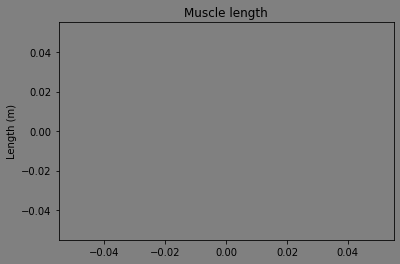

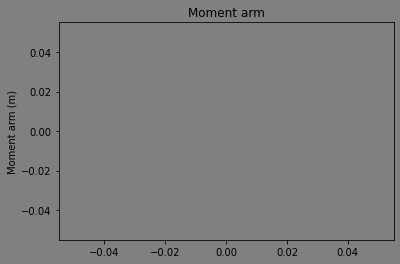

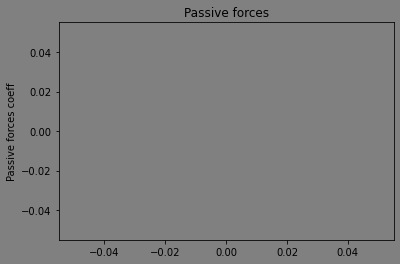

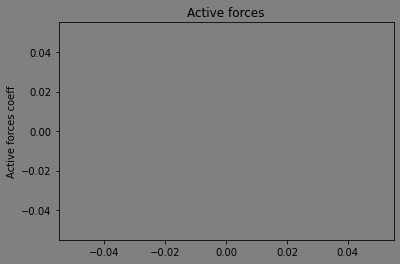

In [14]:
import numpy as np
# biomechanics software pyomeca biorbd and bioviz
import biorbd
import bioviz
# scipy to handle quaternions
from scipy.spatial.transform import Rotation as R

# Load a predefined model
model = biorbd.Model("pyomeca_models/MOBL_ARMS_fixed_33_movingbase.bioMod")
nq = model.nbQ()
nb_mus = model.nbMuscles()

# get min and max joint angles
Q_min = []
Q_max= []
for s in range(model.nbSegment()):
    for i in model.segment(s).QRanges():
        Q_min.append(i.min())
        Q_max.append(i.max())
Q_min = np.array(Q_min)
Q_max = np.array(Q_max)

# inital configuration - first kalman step
qinit = np.array([ -0.04748828,  1.04941699,  0.11751443,  1.10589953, -0.06330007,
        0.42163834,  0.057855 ])

# the generalised coordinates of the model
Q = biorbd.GeneralizedCoordinates(qinit)
Qdot = biorbd.GeneralizedVelocity(model)
Qddot = biorbd.GeneralizedAcceleration(model)

# Create a Kalman filter structure
freq = 1000  # Hz
params = biorbd.KalmanParam(freq)
# kalman = biorbd.KalmanReconsMarkers(model, params)
kalman = biorbd.KalmanReconsIMU(model, params)

# function normalising an angle between -pi and pi
# trying to keep it in the joint limits as well
# its not a hard limit
#
# @param angles: np.array or scalr - joint angles
# @param q_min: np.array or scalr - joint angles min
# @param q_max: np.array or scalr - joint angles max
def normalize(angles, q_min, q_max): 
    norm_angle = angles - np.floor(angles/(2*np.pi)+0.5)*2*np.pi
    norm_angle[norm_angle > q_max] -= 2*np.pi 
    norm_angle[norm_angle < q_min] += 2*np.pi
    return norm_angle

# bioviz viewer intialisation 
# many parameters, mostly to disable stuff that are visualised by default
# they are changing a lot so you might need to add new parameters with new versions
b = bioviz.Viz(loaded_model=model,
               background_color=(1,1,1), 
               show_gravity_vector=False,
               show_floor=False,
               show_local_ref_frame=False, 
               show_global_ref_frame=False, 
               show_markers=False,
               show_global_center_of_mass=False,
               show_segments_center_of_mass=False, 
               show_wrappings=False)

# visualisation downsamplig
downsample = 10
while b.vtk_window.is_active:
    if q is not None:
        # construct an array with all the imu transformation matrices
        # - base
        # - biceps
        # - forearm
        # - hand
        wit_data = np.hstack(((R.from_quat(q[3])).as_matrix()[:3,:3].T.flatten(),
                            (R.from_quat(q[0])).as_matrix()[:3,:3].T.flatten(),
                            (R.from_quat(q[1])).as_matrix()[:3,:3].T.flatten(),
                            (R.from_quat(q[2])).as_matrix()[:3,:3].T.flatten()))
        
        # run the IK using the kalman filter
        kalman.reconstructFrame(model, wit_data, Q, Qdot, Qddot)
        
        # normalise angles between -pi and pi
        Q = normalize(Q.to_array(), Q_min, Q_max)
        Q = biorbd.GeneralizedCoordinates(Q)
        
        # downsample the visualisation
        downsample = downsample + 1
        if downsample > 50:
            b.set_q(Q.to_array())
            b.update()
            downsample = 0 